In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
clean_data = pd.read_csv("data/cleanned_data.csv")
def plot_laps(data, y_col="BRAKE", distance_range=(0, 350),
              exclude_laps=None, only_valid=True,
              figsize=(12, 8), point_size=1):
    """
    Plot lap data with LAPDISTANCE on the x-axis and a chosen column on the y-axis.

    Parameters
    ----------
    data : pd.DataFrame
        The cleaned lap data.
    y_col : str, default="BRAKE"
        Column to plot against LAPDISTANCE.
    distance_range : tuple, default=(0, 300)
        (min_distance, max_distance) range for LAPDISTANCE.
    exclude_laps : list or set, optional
        Laps to exclude from plotting.
    only_valid : bool, default=True
        If True, filter out invalid laps.
    figsize : tuple, default=(12, 8)
        Figure size.
    point_size : int, default=1
        Scatter point size.
    """

    d = data.copy()

    # Filter invalid laps
    if only_valid:
        d = d[d["invalid_lap"] == 0]

    # Exclude laps
    if exclude_laps is not None:
        d = d[~d["lap_id"].isin(exclude_laps)]

    # Distance filter
    d = d[(d["LAPDISTANCE"] >= distance_range[0]) &
          (d["LAPDISTANCE"] <= distance_range[1])]

    # Plot
    plt.figure(figsize=figsize)
    plt.scatter(d["LAPDISTANCE"], d[y_col], s=point_size, c=d["lap_id"])
    plt.xlabel("LAPDISTANCE")
    plt.ylabel(y_col)
    plt.title(f"{y_col} vs LAPDISTANCE")
    # plt.colorbar(label="lap_id")
    plt.show()


In [52]:
clean_data.columns

Index(['Unnamed: 0', 'SESSION_GUID', 'CURRENTLAPNUM', 'SESSIONUID', 'SPEED',
       'THROTTLE', 'STEER', 'BRAKE', 'GEAR', 'ENGINERP1', 'DRS',
       'BRAKESTEMPERATURE_RL', 'BRAKESTEMPERATURE_RR', 'BRAKESTEMPERATURE_FL',
       'BRAKESTEMPERATURE_FR', 'TYRESPRESSURE_RL', 'TYRESPRESSURE_RR',
       'TYRESPRESSURE_FL', 'TYRESPRESSURE_FR', 'CURRENTLAPTIMEINMS',
       'LAPDISTANCE', 'TOTALDISTANCE', 'CURRENTLAPNU1', 'CURRENTLAPINVALID',
       'WORLDPOSITIONX', 'WORLDPOSITIONY', 'WORLDPOSITIONZ',
       'WORLDFORWARDDIRX', 'WORLDFORWARDDIRY', 'WORLDFORWARDDIRZ',
       'WORLDRIGHTDIRX', 'WORLDRIGHTDIRY', 'WORLDRIGHTDIRZ', 'YAW', 'PITCH',
       'ROLL', 'FRONTWHEELSANGLE', 'TRACKID', 'R_STATUS', 'LAPTIME',
       'CURRENTLAPTIME', 'left_dist', 'right_dist', 'l_width', 'r_width',
       'dist_apex_1', 'dist_apex_2', 'angle_to_apex1', 'angle_to_apex2',
       'invalid_lap', 'lap_id'],
      dtype='object')

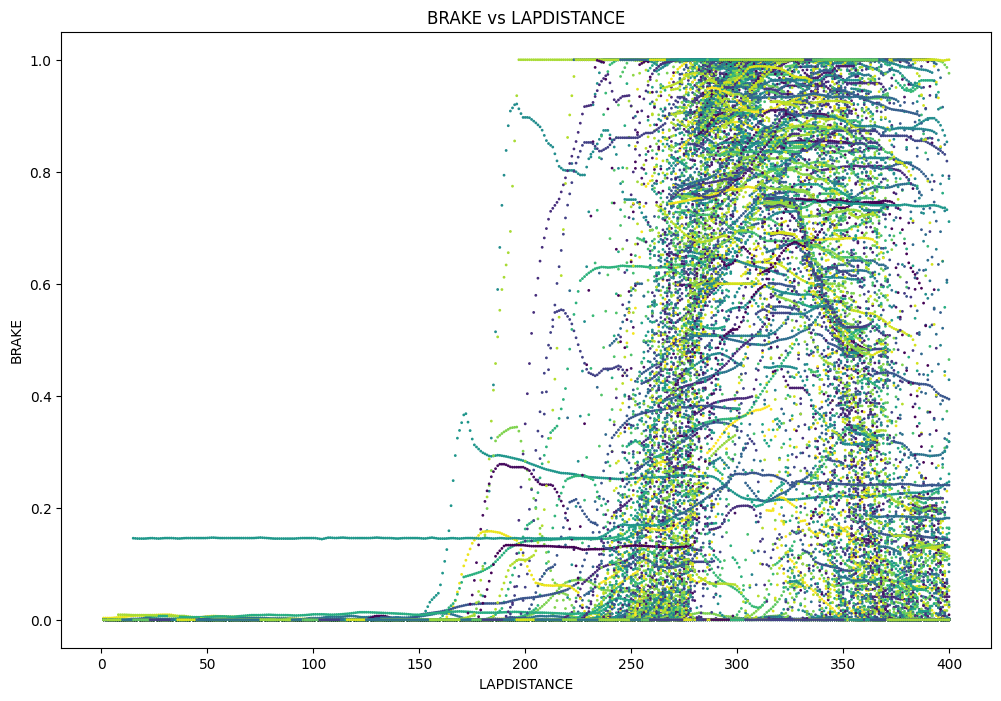

In [9]:
plot_laps(clean_data, distance_range=(0, 400))

In [12]:
d = clean_data[(clean_data["LAPDISTANCE"] < 350) & (clean_data["invalid_lap"] == 0)]
d = d.sort_values(by=["lap_id", "LAPDISTANCE"])
d["brake-diff"] = d["BRAKE"].diff()

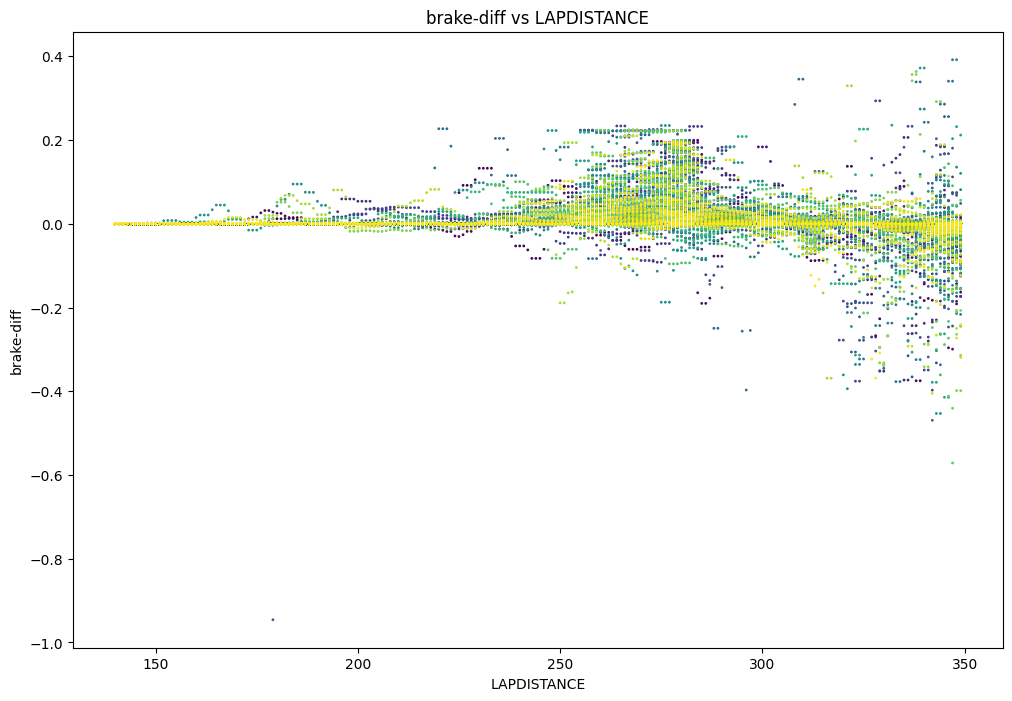

In [22]:
plot_laps(d[["brake-diff", "invalid_lap", "LAPDISTANCE", "BRAKE", "lap_id"]], distance_range=(140, 350), y_col="brake-diff")

In [54]:
n1040 = d[d['lap_id'] == 1040]
n1040

,Unnamed: 0,SESSION_GUID,CURRENTLAPNUM,SESSIONUID,SPEED,THROTTLE,STEER,BRAKE,GEAR,ENGINERP1,DRS,BRAKESTEMPERATURE_RL,BRAKESTEMPERATURE_RR,BRAKESTEMPERATURE_FL,BRAKESTEMPERATURE_FR,TYRESPRESSURE_RL,TYRESPRESSURE_RR,TYRESPRESSURE_FL,TYRESPRESSURE_FR,CURRENTLAPTIMEINMS,LAPDISTANCE,TOTALDISTANCE,CURRENTLAPNU1,CURRENTLAPINVALID,WORLDPOSITIONX,WORLDPOSITIONY,WORLDPOSITIONZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ,YAW,PITCH,ROLL,FRONTWHEELSANGLE,TRACKID,R_STATUS,LAPTIME,CURRENTLAPTIME,left_dist,right_dist,l_width,r_width,dist_apex_1,dist_apex_2,angle_to_apex1,angle_to_apex2,invalid_lap,lap_id,brake-diff
1130982,1130982,2F7A94F2DE7920FBE0631318000A9139,1,18118211511852837828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,1,1.0,1,0,113.222833,466.452350,3.096383,-23346.0,-88.0,-22992.0,22980.0,933.0,-23338.0,-2.348545,0.002692,-0.028506,0.000000,0,NaN,1:24.425,0:00.016,2.649972,3.606066,4.471361,0.000000,380.018924,455.085186,43.442082,33.970537,0,1040,NaN
1130983,1130983,2F7A94F2DE7920FBE0631318000A9139,1,18118211511852837828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,2,2.0,1,0,113.937076,465.751496,3.093212,-23347.0,-101.0,-22991.0,22979.0,927.0,-23340.0,-2.348486,0.003084,-0.028321,0.000000,0,NaN,1:24.425,0:00.016,2.587398,4.559790,6.192718,0.000000,379.018798,454.104149,43.405215,33.913784,0,1040,NaN
1130984,1130984,2F7A94F2DE7920FBE0631318000A9139,1,18118211511852837828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,3,3.0,1,0,114.651318,465.050642,3.090041,-23349.0,-114.0,-22989.0,22977.0,921.0,-23342.0,-2.348427,0.003477,-0.028136,0.000000,0,NaN,1:24.425,0:00.016,2.576109,5.530130,6.192718,0.000000,378.018674,453.123198,43.368337,33.856938,0,1040,NaN
1130985,1130985,2F7A94F2DE7920FBE0631318000A9139,1,18118211511852837828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65,4,4.0,1,0,115.365560,464.349788,3.086871,-23350.0,-127.0,-22988.0,22976.0,915.0,-23343.0,-2.348368,0.003870,-0.027952,0.000000,0,NaN,1:24.425,0:00.016,2.697870,6.509660,8.025239,0.000000,377.018553,452.142332,43.331425,33.799976,0,1040,NaN
1130986,1130986,2F7A94F2DE7920FBE0631318000A9139,1,18118211511852837828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,5,5.0,1,0,116.079418,463.648572,3.081950,-23352.0,-134.0,-22986.0,22974.0,913.0,-23345.0,-2.348309,0.004096,-0.027905,0.000000,0,NaN,1:24.425,0:00.066,2.633392,7.494669,8.944558,0.000000,376.018438,451.161470,43.309305,33.757710,0,1040,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941696,941696,2F7A94F2DE7920FBE0631318000A9139,1,18118211511852837828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4431,345,345.0,1,0,361.244125,228.113257,2.508440,-21215.0,-48.0,-24968.0,24966.0,-427.0,-21213.0,-2.437280,0.001476,0.013034,0.073119,0,NaN,1:24.425,0:04.416,2.636231,13.269831,15.888148,15.880965,39.298477,138.326947,21.249654,3.055537,0,1040,NaN
1163721,1163721,2F7A94F2DE7920FBE0631318000A9139,1,18118211511852837828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4454,346,346.0,1,0,361.901957,227.353242,2.514736,-20902.0,-106.0,-25232.0,25229.0,-436.0,-20899.0,-2.449776,0.003244,0.013301,0.078213,0,NaN,1:24.425,0:04.416,2.725683,13.226289,15.949533,15.924140,38.352422,137.532928,20.587496,2.638575,0,1040,NaN
1163722,1163722,2F7A94F2DE7920FBE0631318000A9139,1,18118211511852837828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4473,347,347.0,1,0,362.550504,226.583763,2.520061,-20563.0,-157.0,-25507.0,25505.0,-435.0,-20560.0,-2.463099,0.004803,0.013273,0.082981,0,NaN,1:24.425,0:04.466,2.828815,13.171230,16.012580,15.985200,37.403809,136.732667,19.932440,2.236754,0,1040,NaN
1163723,1163723,2F7A94F2DE7920FBE0631318000A9139,1,18118211511852837828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [48]:
def get_braking_point(df):
    results =[]

    for lap_id, group in df.groupby("lap_id"):
        group = group.sort_values("LAPDISTANCE").reset_index(drop=True)

        if group["BRAKE"].isna().all():
            results.append({
            'lap_id': lap_id,
            'max_brake_LD': None,
            'BP_LD': None
            })
            continue

        max_idx = group["BRAKE"].idxmax()

        if pd.isna(max_idx) or max_idx not in group.index:
            max_brake_LD = None
            bp_ld = None
        else:
            max_brake_LD = group.loc[max_idx, "LAPDISTANCE"]
            
            try:
                before_max_idx = group.loc[:group.index.get_loc(max_idx)]
            except KeyError:
                before_max_idx = group.copy()

            zero_brake = before_max_idx[before_max_idx["BRAKE"] == 0]

            if not zero_brake.empty:
                bp_ld = zero_brake["LAPDISTANCE"].iloc[-1]
            elif not before_max_idx.empty:
                bp_ld = before_max_idx["LAPDISTANCE"].iloc[0]
            else:
                bp_ld = None

        results.append({
            'lap_id': lap_id,
            'max_brake_LD': max_brake_LD,
            'BP_LD': bp_ld
        })

    return pd.DataFrame(results)

In [49]:
get_braking_point(d)

,lap_id,max_brake_LD,BP_LD
0,1,328.0,177.0
1,5,285.0,271.0
2,13,347.0,261.0
3,15,297.0,224.0
4,18,305.0,261.0
...,...,...,...
397,1040,NaN,NaN
398,1043,276.0,262.0
399,1044,283.0,251.0
400,1045,289.0,250.0
